# AllConv Net

A parameter efficient ConvNet is compared with a [ResNet](https://arxiv.org/abs/1512.03385)-version of the same net.

## The all-convolutional net

From ["Striving for Simplicity: The All Convolutional Net" from Springenberg et. al](https://arxiv.org/abs/1412.6806). This architecture simply downsamples the input with a couple of convolutions as in regular convolutional nets. Then, it arrives at a number of channels that is equal to the number of classes. Taking the mean of each channel (a feature map of very small height and width) gives a vector of the same length as the number of classes - the same output as in a fully connected layer. In this implementation, this architecture has only ~0.3 million parameters when starting with 32 channels. Downsampling is done with stride=2 convolutions.

It's easy to extend the architecture with optional residual shortcuts. This allows to compare the residual version with the non-residual version of the same net.

Interesting, Adam doesn't work at all with this net. Hence, I use only SGD with momentum.

In [1]:
import os

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision import datasets
import torchvision

import sys
sys.path.append('../utils')
sys.path.append('../models')
import utils
import all_conv_net

In [2]:
data_dir = '../data'

# values for normalisation
channel_means = (0.5071, 0.4865, 0.4409)
channel_standard_devs = (0.2673, 0.2564, 0.2762)

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_standard_devs)
])
batchsize=64

test_set = datasets.CIFAR100(data_dir, train=False, transform=transformation, download=True)
test_loader = DataLoader(test_set, batch_size=batchsize)

rest = datasets.CIFAR100(data_dir, train=True, transform=transformation, download=True)
train_loader, validation_loader = utils.train_validation_split(rest, fraction=0.1, batchsize=batchsize)

print(f'training batches: {len(train_loader)}')
print(f'validation batches: {len(validation_loader)}')
print(f'test batches: {len(test_loader)}')
print(f'batch size: {batchsize}')

Files already downloaded and verified
Files already downloaded and verified
training batches: 704
validation batches: 79
test batches: 157
batch size: 64


### Dimensions

#### convolutional layer

$$W_{output} = \Bigl\lfloor \frac{W_{input} - F + 2*P}{S} \Bigr\rfloor+ 1$$

#### pooling layer

$$W_{output} = \frac{W_{input} - F}{S} + 1$$

with:  
W: width
F: filter width  
P: padding  
S: stride

... same goes for height (images are quadratic anyway)

In [5]:
#( (16 - 3 + 2*1 ) / 2 ) + 1

In [6]:
print('MODEL: all-convolution net')
net = all_conv_net.AllCNN(c=64, residuals=False)
print(f'parameters: {utils.count_parameters(net, in_millions=True):.2f} million\n')

optimizer = torch.optim.SGD(net.parameters(),
                            lr=0.1,
                            momentum=0.9,
                            weight_decay=0  #0.00002
                           )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.75, patience=5, threshold=0.01, verbose=True)

utils.train_model(net, train_loader, validation_loader, optimizer, scheduler, max_epoch=200)

MODEL: all-convolution net
parameters: 1.39 million

epoch	training-CE	validation-CE	validation-accuracy (%)
0	4.55		4.43		0.00
1	4.43		4.29		12.50
2	4.34		4.15		12.50
3	4.27		4.07		25.00
4	4.19		3.93		0.00
5	4.11		3.82		12.50
6	4.05		3.70		12.50
7	3.99		3.63		12.50
8	3.94		3.58		12.50
9	3.86		3.42		12.50
10	3.81		3.30		12.50
11	3.75		3.27		12.50
12	3.70		3.19		25.00
13	3.65		3.10		12.50
14	3.60		3.07		12.50
15	3.58		2.99		25.00
16	3.52		2.91		25.00
17	3.49		2.84		25.00
18	3.46		2.82		12.50
19	3.41		2.78		12.50
20	3.37		2.74		25.00
21	3.34		2.66		25.00
22	3.31		2.61		37.50
23	3.28		2.59		25.00
24	3.24		2.56		25.00
25	3.22		2.50		25.00
26	3.18		2.44		12.50
27	3.17		2.45		12.50
28	3.15		2.41		25.00
29	3.13		2.38		25.00
30	3.07		2.31		50.00
31	3.05		2.26		25.00
32	3.05		2.29		25.00
33	3.01		2.26		25.00
34	3.01		2.23		37.50
35	2.98		2.22		25.00
36	2.98		2.23		50.00
37	2.94		2.20		37.50
38	2.92		2.15		37.50
39	2.90		2.14		50.00
40	2.90		2.09		37.50
41	2.89		2.11		37.50
42	2.88		2.08		37.50


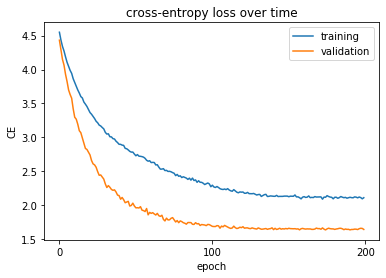


Evaluation on the test-set:
mean batch cross-entropy loss: 1.64
accuracy: 61.46


In [7]:
utils.plot_error_curves(utils.error_stats, error_name='cross-entropy loss')

net.load_state_dict(torch.load(f'{net.__class__.__name__}_best.pt'))
utils.test_set_evaluation(net.cuda(), test_loader, just_print=True)

Weird observation:  
Validation error is consistently lower than training error.

## The all convolutional ResNet

Compare the above results with the same architecture (and the same optimization strategy) with the addition of residual shortcuts.

In [9]:
print('MODEL: all-convolution ResNet')
net = all_conv_net.AllCNN(c=64, residuals=True)  # same net with residual shortcuts!
print(f'parameters: {utils.count_parameters(net, in_millions=True):.2f} million\n')

optimizer = torch.optim.SGD(net.parameters(),
                            lr=0.1,
                            momentum=0.9,
                            weight_decay=0
                           )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.75, patience=5, threshold=0.01, verbose=True)

utils.train_model(net, train_loader, validation_loader, optimizer, scheduler, max_epoch=200)

MODEL: all-convolution ResNet
parameters: 1.39 million

epoch	training-CE	validation-CE	validation-accuracy (%)
0	4.61		4.60		0.00
1	4.58		4.56		12.50
2	4.56		4.52		0.00
3	4.53		4.49		12.50
4	4.51		4.44		12.50
5	4.48		4.40		12.50
6	4.45		4.37		12.50
7	4.41		4.32		12.50
8	4.39		4.27		25.00
9	4.35		4.24		25.00
10	4.32		4.15		25.00
11	4.30		4.15		25.00
12	4.27		4.09		25.00
13	4.23		4.06		37.50
14	4.20		4.02		25.00
15	4.16		3.93		25.00
16	4.13		3.92		37.50
17	4.09		3.86		25.00
18	4.06		3.80		25.00
19	4.02		3.74		25.00
20	3.99		3.72		25.00
21	3.94		3.65		25.00
22	3.90		3.57		25.00
23	3.86		3.52		25.00
24	3.83		3.48		25.00
25	3.78		3.45		25.00
26	3.76		3.40		25.00
27	3.72		3.38		37.50
28	3.69		3.36		37.50
29	3.65		3.29		37.50
30	3.63		3.26		37.50
31	3.59		3.24		12.50
32	3.56		3.17		25.00
33	3.54		3.14		25.00
34	3.50		3.12		37.50
35	3.46		3.09		25.00
36	3.41		3.02		37.50
37	3.37		2.98		50.00
38	3.34		2.96		37.50
39	3.30		2.90		37.50
40	3.27		2.83		50.00
41	3.23		2.81		50.00
42	3.20		2.81		50.

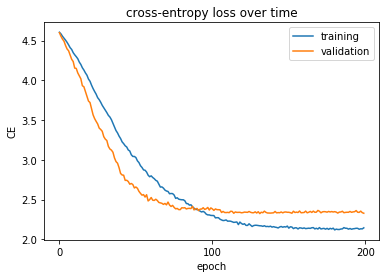


Evaluation on the test-set:
mean batch cross-entropy loss: 2.37
accuracy: 49.56


In [10]:
utils.plot_error_curves(utils.error_stats, error_name='cross-entropy loss')

net.load_state_dict(torch.load(f'{net.__class__.__name__}_best.pt'))
utils.test_set_evaluation(net.cuda(), test_loader, just_print=True)

Interestingly, the no-shortcut version does better than the residual-shortcut version :-)

The all-conv architecture, while being very parameter-efficient, is probably not the best example to demonstrate residual-shortcuts because ResNets have been developed using a standard conv-net architecture (conv-layers + fully connected classifier). Combining the all-conv architecture with residual shortcuts might require some additional adaptations.